In [80]:
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [120]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

### dataset preparation

The token we work with is a single character (for simplicity).
Our model will train to predict next token given previous context of 3 tokens (3-grams)

In [55]:
# read names
with open("names.txt", "r") as fnames:
    names = fnames.read().splitlines()
names_cnt = len(names)
print('names:')
for name in names[:5]:
    print(name)
print(f'total names count: {names_cnt}')

# building vocabulary
special_tokens = ['.'] # represents the start and the end of each name.
vocab = special_tokens + sorted(list(set(''.join(names))))
vocab_size = len(vocab)
print(f'{vocab=}')
print(f'{vocab_size=}')

# mapping from chars to token number and vice-versa
ctoi = {c:i for i,c in enumerate(vocab)}
itoc = vocab
encode = lambda char_seq: [ctoi[c] for c in char_seq]
decode = lambda token_num_seq: [itoc[t] for t in token_num_seq]
print(encode("vlad"), decode([22,12,1,4]))

# prepare dataset for NN training and validation
block_size = 3 # represents the length of context
X, y = [], []
for name in names:
    block = torch.zeros(block_size).to(torch.int64)
    for c in name + '.':
        ix = ctoi[c]
        X.append(block)
        y.append(ix)
        block = block.roll(-1)
        block[-1] = ix
X, y = torch.stack(X), torch.tensor(y)
print(f'{X.shape=}, {y.shape=}')
for i in range(25):
    print(f'{"".join(decode(X[i]))} => {itoc[y[i]]}')

train_size = int(0.8*X.shape[0])
val_size   = X.shape[0] - train_size
train_ids, val_ids = torch.arange(X.shape[0]).split([train_size, val_size])
train_X, val_X = X[train_ids], X[val_ids]
train_y, val_y = y[train_ids], y[val_ids]
print(f'{train_X.shape=}, {val_X.shape=}, {train_y.shape=}, {val_y.shape=}')

names:
emma
olivia
ava
isabella
sophia
total names count: 32033
vocab=['.', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']
vocab_size=27
[22, 12, 1, 4] ['v', 'l', 'a', 'd']
X.shape=torch.Size([228146, 3]), y.shape=torch.Size([228146])
... => e
..e => m
.em => m
emm => a
mma => .
... => o
..o => l
.ol => i
oli => v
liv => i
ivi => a
via => .
... => a
..a => v
.av => a
ava => .
... => i
..i => s
.is => a
isa => b
sab => e
abe => l
bel => l
ell => a
lla => .
train_X.shape=torch.Size([182516, 3]), val_X.shape=torch.Size([45630, 3]), train_y.shape=torch.Size([182516]), val_y.shape=torch.Size([45630])


### Build multi-layer perceptron (MLP) model

here we are building something like "Bengio et al. 2003 A Neural Probabilistic Language Model" paper

In [130]:
class MLP:
    def __init__(self, vocab_size, block_size, emb_size, hidden_size, device='cpu'):
        self.emb = torch.randn((vocab_size, emb_size), requires_grad = True, device = device)
        self.W1 = torch.randn((block_size*emb_size, hidden_size), requires_grad = True, device = device)
        self.b1 = torch.randn(hidden_size, requires_grad = True, device = device)
        self.W2 = torch.randn((hidden_size, vocab_size), requires_grad = True, device = device)
        self.b2 = torch.randn(vocab_size, requires_grad = True, device = device)
    
    def forward(self, mini_batch_X):
        embeddings  = self.emb[mini_batch_X]
        concat_embs = embeddings.view(mini_batch_X.shape[0], -1)
        out1 = concat_embs @ self.W1 + self.b1
        out1 = F.tanh(out1)
        out2 = out1 @ self.W2 + self.b2
        return F.softmax(out2, dim=1)

    def zero_grad(self):
        self.emb.grad = None
        self.W1.grad = None
        self.b1.grad = None
        self.W2.grad = None
        self.b2.grad = None

    def optimize(self, lr=1e-3):
        self.b2.data -= lr*self.b2.grad
        self.W2.data -= lr*self.W2.grad
        self.b1.data -= lr*self.b1.grad
        self.W1.data -= lr*self.W1.grad
        self.emb.data -= lr*self.emb.grad
    
    def __call__(self, mini_batch_X):
        return self.forward(mini_batch_X)


model = MLP(vocab_size, block_size, emb_size=4, hidden_size=128, device=device)
model(torch.arange(12).reshape(4,3)).shape

torch.Size([4, 27])

In [131]:
def nll_loss(probs, y):
    return -probs[torch.arange(probs.shape[0]), y.flatten()].log().mean()


def train(model, train_X, train_y, val_X, val_y, epoches, batch_size):
    train_loss, val_loss = [], []
    for epoch in range(epoches):
        ids = torch.randperm(train_X.shape[0])
        cur_losses = []
        for batch_ids_lb in range(0, train_X.shape[0], batch_size):
            batch_ids = ids[batch_ids_lb:batch_ids_lb+batch_size]
            mini_batch_X = train_X[batch_ids].to(device)
            mini_batch_y = train_y[batch_ids].to(device)
            probs = model(mini_batch_X)
            loss = nll_loss(probs, mini_batch_y)
            cur_losses.append(loss.item())
            model.zero_grad()
            loss.backward()
            model.optimize()
        cur_avg_train_loss = sum(cur_losses) / len(cur_losses)
        cur_val_loss = nll_loss(model(val_X), val_y).item()
        print(f'{epoch=}: {cur_avg_train_loss=}, {cur_val_loss=}')
        train_loss.append(cur_avg_train_loss)
        val_loss.append(cur_val_loss)
    return train_loss, val_loss

In [132]:
train_loss, val_loss = train(model, train_X, train_y, val_X, val_y, epoches=40, batch_size=32)

epoch=0: cur_avg_train_loss=10.17875754431956, cur_val_loss=7.464056491851807
epoch=1: cur_avg_train_loss=5.1803663551055035, cur_val_loss=4.916943073272705
epoch=2: cur_avg_train_loss=3.847466137390819, cur_val_loss=4.078091144561768
epoch=3: cur_avg_train_loss=3.3623537420808516, cur_val_loss=3.682596445083618
epoch=4: cur_avg_train_loss=3.1013157795304838, cur_val_loss=3.418793201446533
epoch=5: cur_avg_train_loss=2.9258292138283917, cur_val_loss=3.2338552474975586
epoch=6: cur_avg_train_loss=2.8124056946052574, cur_val_loss=3.1175994873046875
epoch=7: cur_avg_train_loss=2.738391508623895, cur_val_loss=3.0257816314697266
epoch=8: cur_avg_train_loss=2.683110358943277, cur_val_loss=2.9586124420166016
epoch=9: cur_avg_train_loss=2.6383232228969957, cur_val_loss=2.9014360904693604
epoch=10: cur_avg_train_loss=2.6007283093802225, cur_val_loss=2.8540704250335693
epoch=11: cur_avg_train_loss=2.570031130318053, cur_val_loss=2.818117380142212
epoch=12: cur_avg_train_loss=2.5465617150820656, 

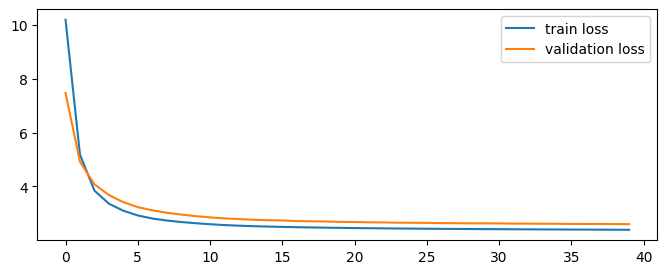

In [133]:
plt.figure(figsize=(8,3))
plt.plot(np.array(train_loss), label = 'train loss')
plt.plot(np.array(val_loss), label = 'validation loss')
plt.legend()

In [134]:
def evaluate(model, max_new_tokens=100):
    result = []
    for t in range(max_new_tokens):
        context = torch.zeros((1, block_size)).to(torch.int64)
        next_token = torch.multinomial(model(context), 1)
        result.append(next_token)
        if next_token == 0:
            break
        context.roll(-1, dims=1)
        context[0, -1] = next_token
    return result

In [135]:
''.join(decode(evaluate(model)))

'oceatrmkmfjhanmzavymjmsnljsysmaasrjmellenejeccnlrrrnbrmcfpkarjoyaltbsyjrjbjmakmsslalfnjmaaaahcajctaj'

In [141]:
for i in range(100,200):
    print(f"{''.join(decode(X[i]))} => {itoc[y[i]]}")

lla => .
... => a
..a => v
.av => e
ave => r
ver => y
ery => .
... => s
..s => o
.so => f
sof => i
ofi => a
fia => .
... => c
..c => a
.ca => m
cam => i
ami => l
mil => a
ila => .
... => a
..a => r
.ar => i
ari => a
ria => .
... => s
..s => c
.sc => a
sca => r
car => l
arl => e
rle => t
let => t
ett => .
... => v
..v => i
.vi => c
vic => t
ict => o
cto => r
tor => i
ori => a
ria => .
... => m
..m => a
.ma => d
mad => i
adi => s
dis => o
iso => n
son => .
... => l
..l => u
.lu => n
lun => a
una => .
... => g
..g => r
.gr => a
gra => c
rac => e
ace => .
... => c
..c => h
.ch => l
chl => o
hlo => e
loe => .
... => p
..p => e
.pe => n
pen => e
ene => l
nel => o
elo => p
lop => e
ope => .
... => l
..l => a
.la => y
lay => l
ayl => a
yla => .
... => r
..r => i
.ri => l
ril => e
ile => y
ley => .
... => z
..z => o
.zo => e
zoe => y
oey => .
... => n
..n => o
.no => r
nor => a
ora => .
... => l
